RQ1: Is there an association between repository activity characteristics (number of commits and number of contributors) and GUI end-to-end testing intensity (number of GUI test files and number of GUI tests) in non-trivial repositories?

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy import stats
from statsmodels.stats.multitest import multipletests

### Load CSV files

In [2]:
repository = pd.read_csv("E2EGit/repository.csv")
non_trivial = pd.read_csv("E2EGit/non_trivial_repository.csv")
gui_repo = pd.read_csv("E2EGit/gui_testing_repo_details.csv")
gui_tests = pd.read_csv("E2EGit/gui_testing_test_details.csv")
perf_tests = pd.read_csv("E2EGit/performance_testing_test_details.csv")

repository.columns = repository.columns.str.strip()
non_trivial.columns = non_trivial.columns.str.strip()
perf_tests.columns = perf_tests.columns.str.strip()

repository = repository.rename(columns={"name": "repository_name",})
non_trivial = non_trivial.rename(columns={"name": "repository_name",})

C:\Users\lungu\AppData\Local\Temp\ipykernel_24072\593322726.py:1: DtypeWarning: Columns (6,7,8,9,14,15,16,24,25,26,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  repository = pd.read_csv("E2EGit/repository.csv")


#### Prepare analysis dataframe

In [3]:
gui_repo_non_trivial = gui_repo.merge(
    non_trivial[["repository_name"]],
    on="repository_name",
    how="inner"
)

gui_by_repo = gui_repo_non_trivial[["repository_name", "number_of_files", "number_of_tests"]].rename(
    columns={"number_of_files": "gui_test_files", "number_of_tests": "gui_tests"}
)

df_analysis = gui_by_repo.merge(repository, on="repository_name", how="inner")

# only repos with at least one GUI test file and at least one GUI test
df_analysis = df_analysis[(df_analysis["gui_test_files"] > 0) & (df_analysis["gui_tests"] > 0)]

print("Repositories:", df_analysis["repository_name"].nunique())
df_analysis.head()


Repositories: 472


,repository_name,gui_test_files,gui_tests,is_fork,commits,branches,releases,forks,main_language,default_branch,...,metrics,last_commit,last_commit_sha,has_wiki,is_archived,is_disabled,is_locked,languages,labels,topics
0,quantumlib/cirq,2,3,0.0,3756.0,89.0,25.0,961.0,Python,main,...,"language:TypeScript, commentLines:744, codeLin...",2024-03-29T07:41:23,2e2ad24380c18afe65f91eea9e2252363665bd1b,1.0,0.0,0.0,0.0,Python; Jupyter Notebook; TypeScript; Shell; D...,announce change; aqt; architecture/ion-trap; a...,cirq; nisq; quantum-algorithms; quantum-circui...
1,wandb/weave,31,31,0.0,2362.0,571.0,0.0,20.0,TypeScript,master,...,"language:Diff, commentLines:6, codeLines:5, bl...",2024-03-26T12:06:31,50611c029730e1be9675c09df2c495b2a849aeda,1.0,0.0,0.0,0.0,TypeScript; Python; C; Jupyter Notebook; HTML;...,bug; dependencies; documentation; duplicate; e...,NaN
2,insightsoftwareconsortium/itk-wasm,37,92,0.0,3489.0,17.0,190.0,45.0,Python,main,...,"language:JSON, commentLines:0, codeLines:29476...",2024-03-26T11:06:27,607eb837124d02024ce6229880c96872db3dce0b,0.0,0.0,0.0,0.0,Python; TypeScript; C++; JavaScript; HTML; CMa...,bug; dependencies; duplicate; enhancement; goo...,asmjs; emscripten; imaging; input-output; insi...
3,codyogden/killedbygoogle,3,8,0.0,2013.0,4.0,0.0,365.0,TypeScript,main,...,"language:YAML, commentLines:0, codeLines:78, b...",2024-03-27T10:24:28,44bfc8873e4c37817641d8f56148d2b2de1a0bc2,0.0,0.0,0.0,0.0,TypeScript; JavaScript; CSS;,bug; dependencies; enhancement; hacktoberfest;...,front-end; google; hacktoberfest; json; open-d...
4,mattermost/mattermost,4,11,0.0,18316.0,688.0,515.0,6795.0,TypeScript,master,...,"language:XML, commentLines:1, codeLines:667, b...",2024-03-28T01:49:42,f34fac77311fca817306c46b37e3933d02e1ae95,0.0,0.0,0.0,0.0,TypeScript; Go; HTML; JavaScript; SCSS; Makefi...,1. ux review; 1: pm review; 2. editor review; ...,collaboration; golang; hacktoberfest; mattermo...


In [4]:
df_analysis = gui_by_repo.merge(repository, on="repository_name", how="inner")
df_analysis = df_analysis[(df_analysis["gui_test_files"] > 0) & (df_analysis["gui_tests"] > 0)]
df_analysis.head()

,repository_name,gui_test_files,gui_tests,is_fork,commits,branches,releases,forks,main_language,default_branch,...,metrics,last_commit,last_commit_sha,has_wiki,is_archived,is_disabled,is_locked,languages,labels,topics
0,quantumlib/cirq,2,3,0.0,3756.0,89.0,25.0,961.0,Python,main,...,"language:TypeScript, commentLines:744, codeLin...",2024-03-29T07:41:23,2e2ad24380c18afe65f91eea9e2252363665bd1b,1.0,0.0,0.0,0.0,Python; Jupyter Notebook; TypeScript; Shell; D...,announce change; aqt; architecture/ion-trap; a...,cirq; nisq; quantum-algorithms; quantum-circui...
1,wandb/weave,31,31,0.0,2362.0,571.0,0.0,20.0,TypeScript,master,...,"language:Diff, commentLines:6, codeLines:5, bl...",2024-03-26T12:06:31,50611c029730e1be9675c09df2c495b2a849aeda,1.0,0.0,0.0,0.0,TypeScript; Python; C; Jupyter Notebook; HTML;...,bug; dependencies; documentation; duplicate; e...,NaN
2,insightsoftwareconsortium/itk-wasm,37,92,0.0,3489.0,17.0,190.0,45.0,Python,main,...,"language:JSON, commentLines:0, codeLines:29476...",2024-03-26T11:06:27,607eb837124d02024ce6229880c96872db3dce0b,0.0,0.0,0.0,0.0,Python; TypeScript; C++; JavaScript; HTML; CMa...,bug; dependencies; duplicate; enhancement; goo...,asmjs; emscripten; imaging; input-output; insi...
3,codyogden/killedbygoogle,3,8,0.0,2013.0,4.0,0.0,365.0,TypeScript,main,...,"language:YAML, commentLines:0, codeLines:78, b...",2024-03-27T10:24:28,44bfc8873e4c37817641d8f56148d2b2de1a0bc2,0.0,0.0,0.0,0.0,TypeScript; JavaScript; CSS;,bug; dependencies; enhancement; hacktoberfest;...,front-end; google; hacktoberfest; json; open-d...
4,mattermost/mattermost,4,11,0.0,18316.0,688.0,515.0,6795.0,TypeScript,master,...,"language:XML, commentLines:1, codeLines:667, b...",2024-03-28T01:49:42,f34fac77311fca817306c46b37e3933d02e1ae95,0.0,0.0,0.0,0.0,TypeScript; Go; HTML; JavaScript; SCSS; Makefi...,1. ux review; 1: pm review; 2. editor review; ...,collaboration; golang; hacktoberfest; mattermo...


### Descriptive Statistics

In [5]:
columns = ["commits", "contributors", "gui_test_files", "gui_tests"]

desc_main = df_analysis[columns].agg(["count", "mean", "median", "std", "min", "max"])
display(desc_main)

print("Min commits/contributors:")
display(df_analysis[["commits", "contributors"]].min())

print("Top 5 repositories by GUI tests:")
display(df_analysis.nlargest(5, "gui_tests")[["commits", "contributors", "gui_test_files", "gui_tests"]])

,commits,contributors,gui_test_files,gui_tests
count,472.000000,472.000000,472.000000,472.000000
mean,10454.483051,130.010593,18.222458,92.521186
median,5588.500000,78.000000,5.000000,19.000000
std,13948.725406,124.418622,47.753606,260.771328
min,2013.000000,10.000000,1.000000,1.000000
max,120214.000000,576.000000,709.000000,3352.000000


Min commits/contributors:


commits         2013.0
contributors      10.0
dtype: float64

Top 5 repositories by GUI tests:


,commits,contributors,gui_test_files,gui_tests
262,12316.0,476.0,100,3352
154,4626.0,104.0,169,2154
100,19182.0,188.0,709,1904
91,13577.0,397.0,399,1627
419,3244.0,58.0,163,1353


### Normality Tests

Shapiro-Wilk

In [6]:
columns = ["commits", "contributors", "gui_test_files", "gui_tests"]
normality_results = {}

print("RQ1:")
for column in columns:
    x = df_analysis[column].dropna()
    stat, p_value = stats.shapiro(x)
    is_normal = p_value > 0.05
    normality_results[column] = is_normal

    print(f"  {column:15s}: W={stat:.4f}, p={p_value:.4f} | "
          f"{'Normal' if is_normal else 'Not Normal'}")

RQ1:
  commits        : W=0.5687, p=0.0000 | Not Normal
  contributors   : W=0.8115, p=0.0000 | Not Normal
  gui_test_files : W=0.3334, p=0.0000 | Not Normal
  gui_tests      : W=0.3413, p=0.0000 | Not Normal


D’Agostino–Pearson

In [7]:
for column in columns:
    x = df_analysis[column].dropna()
    n = len(x)

    if n < 8:
        print(f"  {column:15s}: N={n:4d} | N/A (requires N >= 8)")
        continue

    stat, p_value = stats.normaltest(x)
    is_normal = p_value > 0.05

    print(f"  {column:15s}: N={n:4d}, K2={stat:.4f}, p={p_value:.4g} | "
          f"{'Normal' if is_normal else 'Not Normal'}")

  commits        : N= 472, K2=417.1450, p=2.619e-91 | Not Normal
  contributors   : N= 472, K2=85.0798, p=3.351e-19 | Not Normal
  gui_test_files : N= 472, K2=738.1089, p=5.269e-161 | Not Normal
  gui_tests      : N= 472, K2=656.2189, p=3.191e-143 | Not Normal


### Spearman correlations

In [8]:
# commits vs gui_test_files
tmp = df_analysis[["commits", "gui_test_files"]].dropna()
rho_commits_files, p_commits_files = spearmanr(tmp["commits"], tmp["gui_test_files"])

# commits vs gui_tests
tmp = df_analysis[["commits", "gui_tests"]].dropna()
rho_commits_tests, p_commits_tests = spearmanr(tmp["commits"], tmp["gui_tests"])

# contributors vs gui_test_files
tmp = df_analysis[["contributors", "gui_test_files"]].dropna()
rho_contrib_files, p_contrib_files = spearmanr(tmp["contributors"], tmp["gui_test_files"])

# contributors vs gui_tests
tmp = df_analysis[["contributors", "gui_tests"]].dropna()
rho_contrib_tests, p_contrib_tests = spearmanr(tmp["contributors"], tmp["gui_tests"])

rho_commits_files, p_commits_files, rho_commits_tests, p_commits_tests, rho_contrib_files, p_contrib_files, rho_contrib_tests, p_contrib_tests


(0.15275694579741864,
 0.0008700484613597067,
 0.13386480242625695,
 0.0035717190169637205,
 0.08586018595659795,
 0.0623416856635347,
 0.1007771421331323,
 0.028581541613618477)

### Results table

In [9]:
results = pd.DataFrame([
    {"activity": "commits", "intensity": "gui_test_files", "rho": rho_commits_files, "p": p_commits_files},
    {"activity": "commits", "intensity": "gui_tests",      "rho": rho_commits_tests, "p": p_commits_tests},
    {"activity": "contributors", "intensity": "gui_test_files", "rho": rho_contrib_files, "p": p_contrib_files},
    {"activity": "contributors", "intensity": "gui_tests",      "rho": rho_contrib_tests, "p": p_contrib_tests},
])

results["p_holm"] = multipletests(results["p"], method="holm")[1]

results


,activity,intensity,rho,p,p_holm
0,commits,gui_test_files,0.152757,0.000870,0.003480
1,commits,gui_tests,0.133865,0.003572,0.010715
2,contributors,gui_test_files,0.085860,0.062342,0.062342
3,contributors,gui_tests,0.100777,0.028582,0.057163


### Hexbin plot

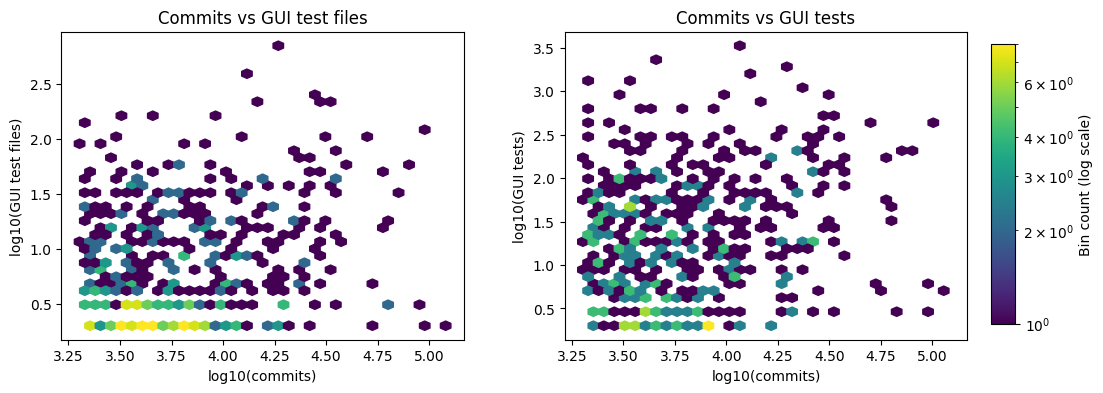

In [10]:
def make_two_panel_hexbin(df, outpath="rq1_hexbin_two_panel.png", gridsize=35):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.subplots_adjust(right=0.88, wspace=0.25)

    pairs = [
        ("commits", "gui_test_files", "log10(commits)", "log10(GUI test files)", "Commits vs GUI test files"),
        ("commits", "gui_tests",      "log10(commits)", "log10(GUI tests)",      "Commits vs GUI tests"),
    ]

    hbs = []
    for ax, (xcolumn, ycolumn, xl, yl, title) in zip(axes, pairs):
        x = df[xcolumn].to_numpy()
        y = df[ycolumn].to_numpy()
        lx = np.log10(x + 1)
        ly = np.log10(y + 1)


        hb = ax.hexbin(lx, ly, gridsize=gridsize, bins='log', mincnt=1)
        hbs.append(hb)
        ax.set_xlabel(xl)
        ax.set_ylabel(yl)
        ax.set_title(title)

    cax = fig.add_axes([0.90, 0.15, 0.02, 0.70]) 
    cbar = fig.colorbar(hbs[0], cax=cax)
    cbar.set_label("Bin count (log scale)")

    fig.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.show()

make_two_panel_hexbin(df_analysis)